# Strategies for computational scaling

In [1]:
import gc
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model.stochastic_gradient import SGDRegressor
from sklearn.svm.classes import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble.forest import RandomForestRegressor

## Training latencies for different models

Perdiction latencies: https://scikit-learn.org/stable/auto_examples/applications/plot_prediction_latency.html#sphx-glr-auto-examples-applications-plot-prediction-latency-py

In [2]:
def generate_dataset(n_samples, n_features, noise=0.1):
    
    print("generating dataset...")

    X, y, coef = make_regression(n_samples=n_samples,
                                 n_features=n_features, 
                                 noise=noise, coef=True)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=5)

    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)

    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train[:, None])[:, 0]
    y_test = y_scaler.transform(y_test[:, None])[:, 0]

    gc.collect()
    
    print('dataset generation complete...')
    
    return X_train, y_train, X_test, y_test

def build_and_train_model(X_train, y_train, model):
    
    training_latencies = []
    
    for i in range(20):
        start = time.time()
        model.fit(X_train, y_train)
        
        training_latencies.append(time.time() - start)
        
   
    return training_latencies

In [3]:
X_train, y_train, X_test, y_test = generate_dataset(10000, 100)

generating dataset...
dataset generation complete...


In [4]:
linear_model = LinearRegression()
lasso_model = Lasso(alpha=0.8)
sgd_model = SGDRegressor(penalty='elasticnet', alpha=0.01,
                         l1_ratio=0.25, tol=1e-4)
sv_model = SVR(kernel='rbf', gamma='scale')
dt_model = DecisionTreeRegressor(max_depth=10)
rf_model = RandomForestRegressor(n_estimators=20)

In [5]:
training_latencies_dict = {}
training_latencies_dict['linear'] = build_and_train_model(X_train,
                                                          y_train,
                                                          linear_model)
training_latencies_dict['lasso'] = build_and_train_model(X_train,
                                                         y_train,
                                                         lasso_model)
training_latencies_dict['sgd'] = build_and_train_model(X_train,
                                                       y_train,
                                                       sgd_model)
training_latencies_dict['sv'] = build_and_train_model(X_train,
                                                      y_train,
                                                      sv_model)
training_latencies_dict['dt'] = build_and_train_model(X_train,
                                                      y_train,
                                                      dt_model)
training_latencies_dict['rf'] = build_and_train_model(X_train,
                                                      y_train,
                                                      rf_model)

In [6]:
training_latencies_df = pd.DataFrame()
for key in training_latencies_dict:
    training_latencies_df[key] = training_latencies_dict[key]
training_latencies_df    

,linear,lasso,sgd,sv,dt,rf
0,0.059685,0.017000,0.064035,3.097007,0.460400,7.047342
1,0.047000,0.013000,0.058967,2.997034,0.461070,7.227702
2,0.044998,0.014000,0.088002,2.960001,0.463115,7.161645
3,0.044001,0.012002,0.061996,3.115500,0.461446,7.043864
4,0.047999,0.011998,0.063034,3.130110,0.462071,6.996443
5,0.044000,0.015000,0.060993,3.100985,0.464055,7.187236
6,0.045000,0.013000,0.060998,3.116422,0.461163,7.030272
7,0.043000,0.014005,0.061007,3.110548,0.460983,7.127899
8,0.045001,0.015996,0.058969,3.403304,0.464807,6.810879
9,0.045000,0.011998,0.060032,3.089869,0.495466,6.901990


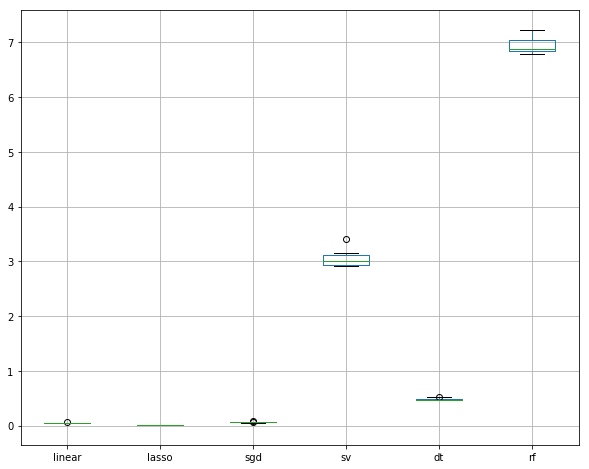

In [7]:
training_latencies_df.boxplot(figsize=(10, 8))

# Scaling of instances using out-of-core learning

In [36]:
import time
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

prod_reviews = pd.read_json('data/elecs_reviews_amzn.json', 
                            lines = True)
prod_reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [37]:
prod_reviews['reviewText'][0]

'We got this GPS for my husband who is an (OTR) over the road trucker.  Very Impressed with the shipping time, it arrived a few days earlier than expected...  within a week of use however it started freezing up... could of just been a glitch in that unit.  Worked great when it worked!  Will work great for the normal person as well but does have the "trucker" option. (the big truck routes - tells you when a scale is coming up ect...)  Love the bigger screen, the ease of use, the ease of putting addresses into memory.  Nothing really bad to say about the unit with the exception of it freezing which is probably one in a million and that\'s just my luck.  I contacted the seller and within minutes of my email I received a email back with instructions for an exchange! VERY impressed all the way around!'

Create 2 classes for the reviews

5-star reviews are tagged "positive", represented with a zero. 1 and 2 stars earn a "negative" tag represented with a 1. Given there are many more positive than negative reviews, assigning 1 to negative reviews helps us calculate precision

In [38]:
prod_reviews.loc[prod_reviews.overall > 4, 'tag'] = 0
prod_reviews.loc[prod_reviews.overall < 3, 'tag'] = 1
prod_reviews = prod_reviews[['reviewText', 'tag']]
prod_reviews.dropna(inplace=True)
prod_reviews.head()

,reviewText,tag
0,We got this GPS for my husband who is an (OTR)...,0.0
1,"I'm a professional OTR truck driver, and I bou...",1.0
3,"Not going to write a long review, even thought...",1.0
4,I've had mine for a year and here's what we go...,1.0
5,I am using this with a Nook HD+. It works as d...,0.0


In [39]:
prod_reviews.groupby(by='tag').count()

,reviewText
tag,
0.0,60287
1.0,11326


In [40]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
prod_reviews['tag'] = label_encoder.fit_transform(prod_reviews['tag'])
prod_reviews.sample(10)

,reviewText,tag
69872,Works great. Used it to split my cable into t...,0
7004,"When I think back to my Commodore 64, I't hard...",0
64486,I was looking for something to carry my gear i...,0
96870,My husband and I attend Diamond Backs and AZ C...,0
73164,Arrived early and in perfect condition. I bou...,1
21957,"First of, I could not buy this amazing piece a...",0
33288,I've used different bulk cables over the years...,0
42166,the IS is amazingly helpful. I took a handheld...,0
49965,This bag is well made and is big enough to hol...,0
49744,I got this lens hoping to improve from my 18-5...,0


In [41]:
prod_reviews.groupby(by='tag').count()

,reviewText
tag,
0,60287
1,11326


Initialize a HashingVectorizer

We use a HashingVectorizer to ensure that the number of features for the text data is constant. This is required as the out-of-core learning means that we will be performing training multiple times and the number of features should be the same irrespective of the corpus

In [42]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(n_features=2 ** 18,
                               alternate_sign=False)

Initialize the SGDClassifier

This is one of the classifiers which includes the partial_fit method for out-of-core learning

In [43]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(prod_reviews['reviewText'], 
                                                    prod_reviews['tag'], 
                                                    test_size=0.2)
x_test = vectorizer.transform(x_test)
batch_size = 500
classes = prod_reviews['tag'].unique()

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

A function to train a classifier in batches

This function will be fed:
* an initialized classifier
* the training data
* the batch size to use for training
* the classes for classifier (required for the partial_fit method)

The training data will be broken up into batches. For each batch, this function will:
* transform the features in the batch using the HashingVectorizer
* run a partial_fit on the data using the classifier

After breaking from the while loop, there will be some samples which are yet to be used for training as their number is less than the batch size. We run partial_fit one final time for this data

In [45]:
def train_classifier(clf, x_train, y_train, batch_size, classes):
    
    
    vectorizing_latencies = []
    training_latencies = []
    prediction_latencies = []
    prediction_accuracies = []
    
    i = 1
    start = 0
    end = batch_size
    
    while (end < x_train.shape[0]):
    
        start_time = time.time()
        x_batch = vectorizer.transform(x_train[start:end])
        
        vectorizing_latencies.append(time.time() - start_time)
        
        y_batch = y_train[start:end]

        start_time = time.time()
        clf.partial_fit(x_batch, 
                        y_batch, 
                        classes=classes)

        training_latencies.append(time.time() - start_time)
        
        start_time = time.time()
        y_pred = clf.predict(x_test)

        prediction_latencies.append(time.time() - start_time)

        prediction_accuracies.append(accuracy_score(y_test, y_pred))
        
        start += batch_size
        end += batch_size
        i += 1
        
    end = x_train.shape[0]
    
    x_batch = vectorizer.transform(x_train[start:end])
    y_batch = y_train[start:end]
    
    clf.partial_fit(x_batch, 
                    y_batch, 
                    classes=classes)
    
    return {'classifier': clf, 
            'vectorizing_latencies': vectorizing_latencies,
            'training_latencies' : training_latencies,
            'prediction_latencies': prediction_latencies, 
            'prediction_accuracies': prediction_accuracies}

Train the SGD classifier

In [48]:
sgd_training_details = train_classifier (sgd_clf, 
                                         x_train, 
                                         y_train, 
                                         batch_size, 
                                         classes)

def convert_to_dataframe(ooc_training_details):
    ooc_training_details_df = pd.DataFrame()

    for key in ooc_training_details:
        if key != 'classifier':
            ooc_training_details_df[key] = ooc_training_details[key]
    
    return ooc_training_details_df

,vectorizing_latencies,training_latencies,prediction_latencies,prediction_accuracies
0,0.060984,0.004093,0.004783,0.913845
1,0.062717,0.002484,0.004275,0.913426
2,0.074200,0.002616,0.003978,0.909795
3,0.089345,0.002780,0.005837,0.894226
4,0.065896,0.002619,0.004942,0.903791
...,...,...,...,...
109,0.065335,0.002230,0.004889,0.909167
110,0.070372,0.002112,0.003700,0.902604
111,0.070595,0.004136,0.004210,0.908818
112,0.066402,0.002138,0.004310,0.904489


In [49]:
sgd_training_details_df = convert_to_dataframe(sgd_training_details)
sgd_training_details_df

,vectorizing_latencies,training_latencies,prediction_latencies,prediction_accuracies
0,0.060984,0.004093,0.004783,0.913845
1,0.062717,0.002484,0.004275,0.913426
2,0.074200,0.002616,0.003978,0.909795
3,0.089345,0.002780,0.005837,0.894226
4,0.065896,0.002619,0.004942,0.903791
...,...,...,...,...
109,0.065335,0.002230,0.004889,0.909167
110,0.070372,0.002112,0.003700,0.902604
111,0.070595,0.004136,0.004210,0.908818
112,0.066402,0.002138,0.004310,0.904489


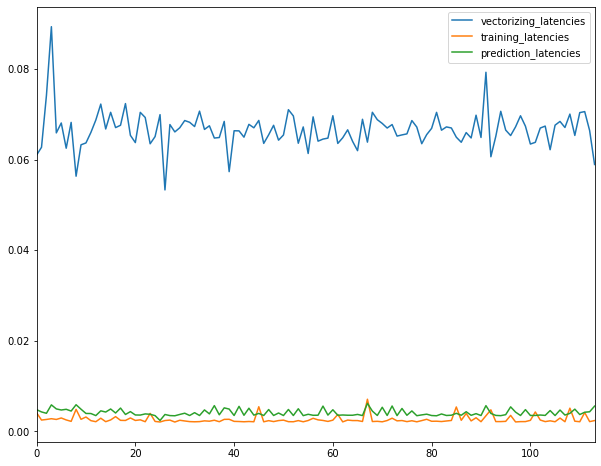

In [50]:
def plot_latency_graphs(training_details_df):
    
    training_details_df[['vectorizing_latencies', 
                         'training_latencies', 
                         'prediction_latencies']].plot(figsize=(10, 8))
    plt.show()
    
plot_latency_graphs(sgd_training_details_df)

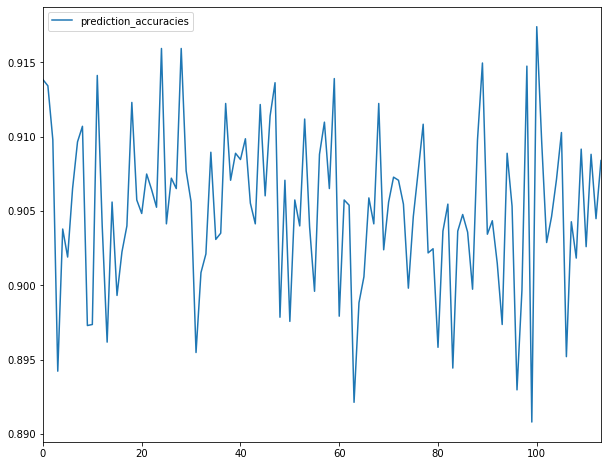

In [51]:
def plot_accuracy_graphs(training_details_df):
    
    training_details_df[['prediction_accuracies']].plot(figsize=(10, 8))
    
    plt.show()
    
plot_accuracy_graphs(sgd_training_details_df)    

Evaluate the other classifiers which support out-of-core learning

In [52]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import BernoulliNB

In [53]:
partial_fit_clfs = {'SGD': SGDClassifier(), 
                    'PassiveAggressive': PassiveAggressiveClassifier(), 
                    'Perceptron': Perceptron(),
                    'BernoulliNB': BernoulliNB()}

SGD
****************************************


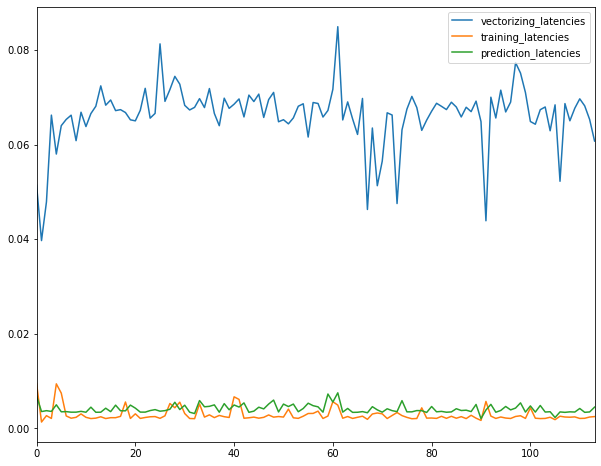

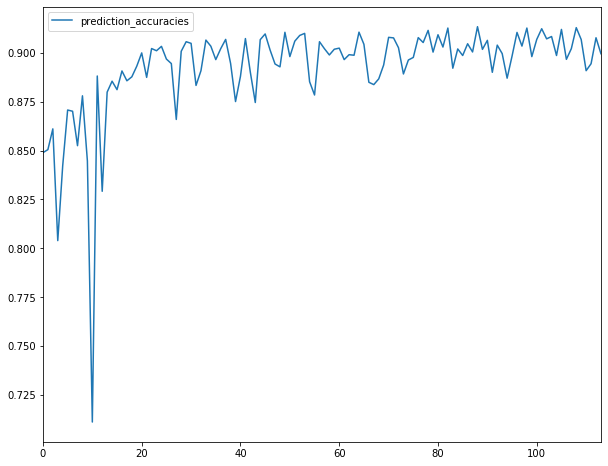

****************************************
PassiveAggressive
****************************************


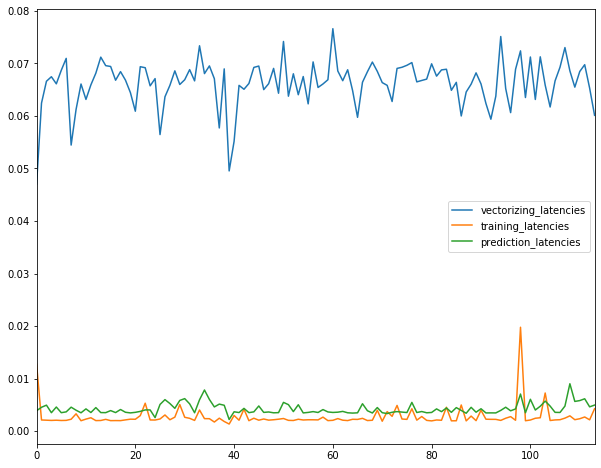

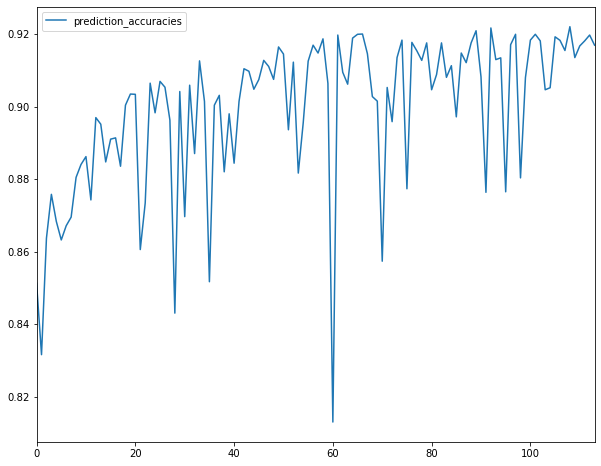

****************************************
Perceptron
****************************************


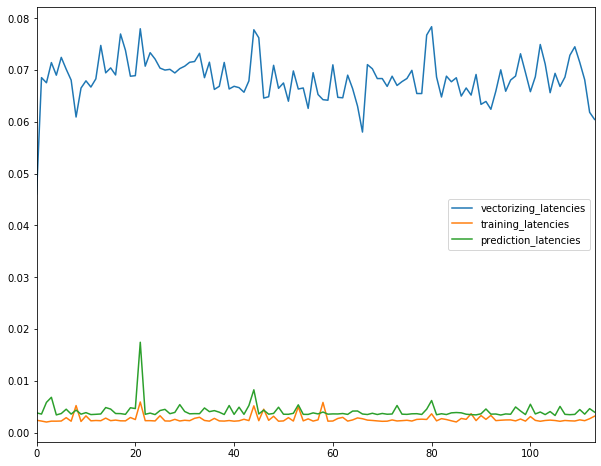

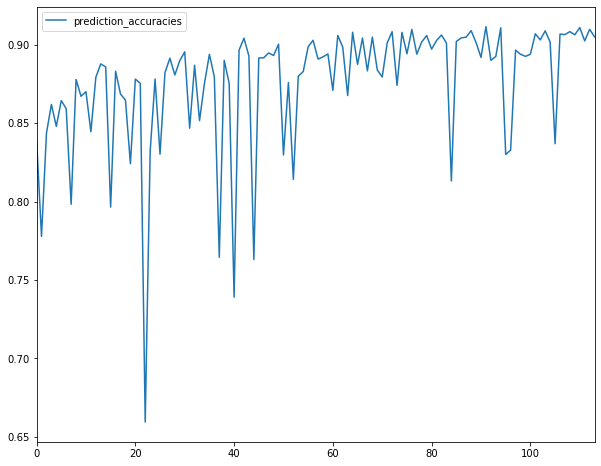

****************************************
BernoulliNB
****************************************


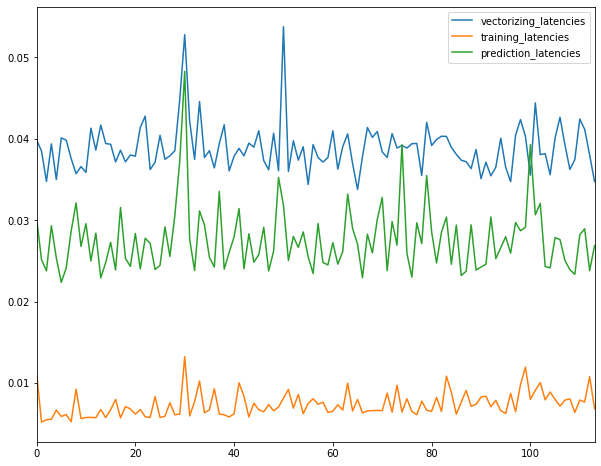

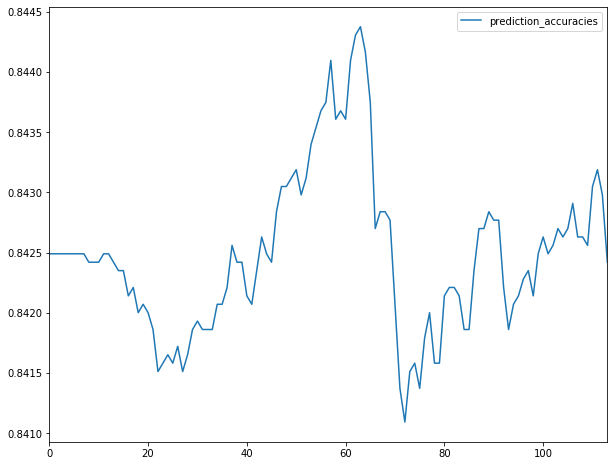

****************************************


In [54]:
for clf_name, clf in partial_fit_clfs.items():

    print(clf_name)
    print('****' * 10)
    
    training_details = train_classifier(clf, 
                                        x_train, 
                                        y_train, 
                                        batch_size, 
                                        classes)

    training_details_df = convert_to_dataframe(training_details)
    
    plot_latency_graphs(training_details_df)
    
    plot_accuracy_graphs(training_details_df)
    
    print('****' * 10)
    sys.stdout.flush()

In [55]:
clf_stats = {}
for clf_name in partial_fit_clfs:
    
    stats = {'accuracy': 0.0, 
             'precision': 0.0,
             'recall' : 0.0}
    
    clf_stats[clf_name] = stats

clf_stats

{'SGD': {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0},
 'PassiveAggressive': {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0},
 'Perceptron': {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0},
 'BernoulliNB': {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0}}

In [56]:
for clf_name, clf in partial_fit_clfs.items():
    
    y_pred = clf.predict(x_test)
    
    clf_stats[clf_name]['accuracy'] = accuracy_score(y_test, y_pred)
    clf_stats[clf_name]['precision'] = precision_score(y_test, y_pred)
    clf_stats[clf_name]['recall'] = recall_score(y_test, y_pred)

In [57]:
import pprint 

pprint.pprint(clf_stats)

{'BernoulliNB': {'accuracy': 0.8421420093555819,
                 'precision': 0.49748237663645517,
                 'recall': 0.21897163120567376},
 'PassiveAggressive': {'accuracy': 0.9190113802974237,
                       'precision': 0.741409691629956,
                       'recall': 0.7460106382978723},
 'Perceptron': {'accuracy': 0.9106332472247434,
                'precision': 0.7606837606837606,
                'recall': 0.6312056737588653},
 'SGD': {'accuracy': 0.9121692382880682,
         'precision': 0.8408469945355191,
         'recall': 0.5456560283687943}}


# Multicore parallelism

In [58]:
!sysctl hw.physicalcpu hw.logicalcpu

sysctl: cannot stat /proc/sys/hw/physicalcpu: No such file or directory
sysctl: cannot stat /proc/sys/hw/logicalcpu: No such file or directory


In [59]:
import time 
from joblib import Parallel, delayed

In [60]:
def work(arg):    
    
    print ("Argument received", arg)
    i, j = arg    

    time.sleep(5)    
    print ("Data merged %s_%s" % (i, j))

    return "%s_%s" % (i, j)

In [61]:
return_val = work((2, 3))

Argument received (2, 3)
Data merged 2_3


In [62]:
return_val

'2_3'

The delayed() function
When used with a map function, the delayed() function initializes the function call with the corresponding arguments without actually executing it. This allows the function call to be set up and then executed concurrently using the joblib.Parallel instance

When called independently, the function will execute.

In [63]:
return_val = delayed(work((2, 3)))
return_val

Argument received (2, 3)
Data merged 2_3


<function joblib.parallel.delayed.<locals>.delayed_function>

In [64]:
return_val()

('2_3', (), {})

The Parallel object
This will create a pool of workers which could be a Thread pool or a Process pool, depending on the value of the "backend" argument. 

In [65]:
Parallel(n_jobs=1, verbose=1, backend="threading")

Parallel(n_jobs=1)

Specify a set of arguments for concurrent instances of the work function
Up to 4 concurrent calls can be invoked

In [66]:
arg_instances = [(1, 1), (1, 2), (1, 3), (1, 4)]

Use the map function
This accepts two arguments:
* the function to execute in each concurrent thread/process
* an iterable of arguments for each function call

In [68]:
start_time = time.time()

Parallel(n_jobs=1, 
         verbose=1, 
         backend="threading")(map(delayed(work), 
                                  arg_instances))

total_time = time.time() - start_time

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Argument received (1, 1)
Data merged 1_1
Argument received (1, 2)
Data merged 1_2
Argument received (1, 3)
Data merged 1_3
Argument received (1, 4)
Data merged 1_4


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.0s finished


In [69]:
print('Total time: ', total_time)

Total time:  20.020103931427002


In [70]:
start_time = time.time()

Parallel(n_jobs=2, 
         verbose=1, 
         backend="threading")(map(delayed(work), 
                                  arg_instances))

total_time = time.time() - start_time
print('Total time: ', total_time)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Argument received (1, 1)
Argument received (1, 2)
Data merged 1_2
Argument received (1, 3)
Data merged 1_1
Argument received (1, 4)
Data merged 1_4
Data merged 1_3
Total time:  10.02695894241333


[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:   10.0s finished


In [71]:
start_time = time.time()

Parallel(n_jobs=4, 
         verbose=1, 
         backend="threading")(map(delayed(work), 
                                  arg_instances))

total_time = time.time() - start_time
print('Total time: ', total_time)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Argument receivedArgument received (1, 2)
 (1, 1)Argument received (1, 3)
Argument received (1, 4)

Data merged 1_2
Data merged 1_1
Data merged 1_3
Data merged 1_4
Total time:  5.015125751495361


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.0s remaining:    5.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.0s finished


Use a multiprocessing backend
This will create a process pool using multiprocessing.Pool. Processes are more heavyweight than threads, but each has its specific use case:
* multithreading: Better for tasks which are I/O or network bound
* multiprocessing: Better for CPU bound tasks

In [72]:
start_time = time.time()

Parallel(n_jobs=3, 
         verbose=1, 
         backend="multiprocessing")(map(delayed(work), 
                                    arg_instances))

total_time = time.time() - start_time
print('Total time: ', total_time)

Argument received (1, 1)
Argument received (1, 2)
Argument received (1, 3)


[Parallel(n_jobs=3)]: Using backend MultiprocessingBackend with 3 concurrent workers.


Data merged 1_1
Argument received (1, 4)
Data merged 1_3
Data merged 1_2
Data merged 1_4
Total time:  10.210429668426514


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed:   10.0s finished


In [73]:
start_time = time.time()

Parallel(n_jobs=4, 
         verbose=1, 
         backend="multiprocessing")(map(delayed(work), 
                                    arg_instances))

total_time = time.time() - start_time
print('Total time: ', total_time)

Argument received (1, 1)


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.


Argument received (1, 3)
Argument received (1, 4)
Argument received (1, 2)
Data merged 1_1
Data merged 1_4
Data merged 1_2
Data merged 1_3
Total time:  5.28214693069458


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.1s remaining:    5.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.1s finished
